<a href="https://colab.research.google.com/github/J1ngy1/CSE510/blob/main/Notebooks/AE_RL_NSL_KDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE-RL for NSL-KDD

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import backend as K
import json
from sklearn.utils import shuffle
import os
import sys
import time

In [ ]:
class data_cls:
    def __init__(self,train_test,**kwargs):
        col_names = ["duration","protocol_type","service","flag","src_bytes",
            "dst_bytes","land_f","wrong_fragment","urgent","hot","num_failed_logins",
            "logged_in","num_compromised","root_shell","su_attempted","num_root",
            "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
            "is_host_login","is_guest_login","count","srv_count","serror_rate",
            "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
            "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
            "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
            "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
            "dst_host_rerror_rate","dst_host_srv_rerror_rate","labels","dificulty"]
        self.index = 0
        # Data formated path and test path.
        self.loaded = False
        self.train_test = train_test
        self.train_path = kwargs.get('train_path', 'datasets/NSL/KDDTrain+.txt')
        self.test_path = kwargs.get('test_path',
                                    'https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTest%2B.txt')

        self.formated_train_path = kwargs.get('formated_train_path',
                                              "formated_train_adv.data")
        self.formated_test_path = kwargs.get('formated_test_path',
                                             "formated_test_adv.data")

        self.attack_types = ['normal','DoS','Probe','R2L','U2R']
        self.attack_names = []
        self.attack_map =   { 'normal': 'normal',

                        'back': 'DoS',
                        'land': 'DoS',
                        'neptune': 'DoS',
                        'pod': 'DoS',
                        'smurf': 'DoS',
                        'teardrop': 'DoS',
                        'mailbomb': 'DoS',
                        'apache2': 'DoS',
                        'processtable': 'DoS',
                        'udpstorm': 'DoS',

                        'ipsweep': 'Probe',
                        'nmap': 'Probe',
                        'portsweep': 'Probe',
                        'satan': 'Probe',
                        'mscan': 'Probe',
                        'saint': 'Probe',

                        'ftp_write': 'R2L',
                        'guess_passwd': 'R2L',
                        'imap': 'R2L',
                        'multihop': 'R2L',
                        'phf': 'R2L',
                        'spy': 'R2L',
                        'warezclient': 'R2L',
                        'warezmaster': 'R2L',
                        'sendmail': 'R2L',
                        'named': 'R2L',
                        'snmpgetattack': 'R2L',
                        'snmpguess': 'R2L',
                        'xlock': 'R2L',
                        'xsnoop': 'R2L',
                        'worm': 'R2L',

                        'buffer_overflow': 'U2R',
                        'loadmodule': 'U2R',
                        'perl': 'U2R',
                        'rootkit': 'U2R',
                        'httptunnel': 'U2R',
                        'ps': 'U2R',
                        'sqlattack': 'U2R',
                        'xterm': 'U2R'
                    }
        self.all_attack_names = list(self.attack_map.keys())

        formated = False

        # Test formated data exists
        if os.path.exists(self.formated_train_path) and os.path.exists(self.formated_test_path):
            formated = True

        self.formated_dir = "../datasets/formated/"
        if not os.path.exists(self.formated_dir):
            os.makedirs(self.formated_dir)


        # If it does not exist, it's needed to format the data
        if not formated:
            ''' Formating the dataset for ready-2-use data'''
            self.df = pd.read_csv(self.train_path,sep=',',names=col_names,index_col=False)
            if 'dificulty' in self.df.columns:
                self.df.drop('dificulty', axis=1, inplace=True) #in case of difficulty

            data2 = pd.read_csv(self.test_path,sep=',',names=col_names,index_col=False)
            if 'dificulty' in data2:
                del(data2['dificulty'])
            train_indx = self.df.shape[0]
            frames = [self.df,data2]
            self.df = pd.concat(frames)

            # Dataframe processing
            self.df = pd.concat([self.df.drop('protocol_type', axis=1), pd.get_dummies(self.df['protocol_type'])], axis=1)
            self.df = pd.concat([self.df.drop('service', axis=1), pd.get_dummies(self.df['service'])], axis=1)
            self.df = pd.concat([self.df.drop('flag', axis=1), pd.get_dummies(self.df['flag'])], axis=1)

            # 1 if ``su root'' command attempted; 0 otherwise
            self.df['su_attempted'] = self.df['su_attempted'].replace(2.0, 0.0)

             # One hot encoding for labels
            self.df = pd.concat([self.df.drop('labels', axis=1),
                            pd.get_dummies(self.df['labels'])], axis=1)


            # Normalization of the df
            #normalized_df=(df-df.mean())/df.std()
            for indx,dtype in self.df.dtypes.items():
                if dtype == 'float64' or dtype == 'int64':
                    if self.df[indx].max() == 0 and self.df[indx].min()== 0:
                        self.df[indx] = 0
                    else:
                        self.df[indx] = (self.df[indx]-self.df[indx].min())/(self.df[indx].max()-self.df[indx].min())


            # Save data
            test_df = self.df.iloc[train_indx:self.df.shape[0]]
            test_df = shuffle(test_df,random_state=np.random.randint(0,100))
            self.df = self.df[:train_indx]
            self.df = shuffle(self.df,random_state=np.random.randint(0,100))
            test_df.to_csv(self.formated_test_path,sep=',',index=False)
            self.df.to_csv(self.formated_train_path,sep=',',index=False)

            # Create a list with the existent attacks in the df
            for att in self.attack_map:
                if att in self.df.columns:
                # Add only if there is exist at least 1
                    if np.sum(self.df[att].to_numpy()) > 1:
                        self.attack_names.append(att)

    def get_shape(self):
        if self.loaded is False:
            self._load_df()

        self.data_shape = self.df.shape
        # stata + labels
        return self.data_shape

    ''' Get n-rows from loaded data
        The dataset must be loaded in RAM
    '''
    def get_batch(self,batch_size=100):
        if self.loaded is False:
            self._load_df()

        # Read the df rows
        indexes = list(range(self.index,self.index+batch_size))
        if max(indexes)>self.data_shape[0]-1:
            dif = max(indexes)-self.data_shape[0]
            indexes[len(indexes)-dif-1:len(indexes)] = list(range(dif+1))
            self.index=batch_size-dif
            batch = self.df.iloc[indexes]
        else:
            batch = self.df.iloc[indexes]
            self.index += batch_size

        labels = batch[self.attack_names]

        batch = batch.drop(self.all_attack_names,axis=1)

        return batch,labels

    def get_full(self):
        if self.loaded is False:
            self._load_df()


        labels = self.df[self.attack_names]

        batch = self.df.drop(self.all_attack_names,axis=1)


        return batch,labels

    def _load_df(self):
        if self.train_test == 'train':
            self.df = pd.read_csv(self.formated_train_path,sep=',') # Read again the csv
        else:
            self.df = pd.read_csv(self.formated_test_path,sep=',')
        self.index=np.random.randint(0,self.df.shape[0]-1,dtype=np.int32)
        self.loaded = True
         # Create a list with the existent attacks in the df
        for att in self.attack_map:
            if att in self.df.columns:
                # Add only if there is exist at least 1
                if np.sum(self.df[att].to_numpy()) > 1:
                    self.attack_names.append(att)
        #self.headers = list(self.df)


In [ ]:
import tensorflow as tf

def huber_loss(y_true, y_pred, clip_value=1.0):
    """
    Simplified Huber Loss function.
    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        clip_value: The threshold where the loss transitions from quadratic to linear.
    Returns:
        Tensor representing the computed Huber loss.
    """
    assert clip_value > 0.0, "clip_value must be positive."

    error = y_true - y_pred
    condition = tf.abs(error) <= clip_value
    squared_loss = 0.5 * tf.square(error)
    linear_loss = clip_value * (tf.abs(error) - 0.5 * clip_value)

    return tf.where(condition, squared_loss, linear_loss)

In [ ]:
from tensorflow import keras

class QNetwork():
    """
    Q-Network Estimator
    Represents the global model for the table
    """

    def __init__(self,obs_size,num_actions,hidden_size = 100,
                 hidden_layers = 1,learning_rate=.2):
        """
        Initialize the network with the provided shape
        """
        self.obs_size = obs_size
        self.num_actions = num_actions

        # Network arquitecture
        self.model = Sequential()
        # Add imput layer
        self.model.add(Dense(hidden_size, input_shape=(obs_size,),
                             activation='relu'))
        # Add hidden layers
        for layers in range(hidden_layers):
            self.model.add(Dense(hidden_size, activation='relu'))
        # Add output layer
        self.model.add(Dense(num_actions))

        #optimizer = optimizers.SGD(learning_rate)
        # optimizer = optimizers.Adam(alpha=learning_rate)
        optimizer = optimizers.Adam(0.00025)
        # optimizer = optimizers.RMSpropGraves(learning_rate, 0.95, self.momentum, 1e-2)

        # Compilation of the model with optimizer and loss
        self.model.compile(loss=huber_loss,optimizer=optimizer)

    def predict(self, state, batch_size=1):
        """
        Predicts action values.
        """
        # Convert to NumPy array with correct dtype
        state = np.asarray(state, dtype=np.float32)

        # Check for NaN or Inf values
        if np.any(np.isnan(state)) or np.any(np.isinf(state)):
            raise ValueError("State contains NaN or Inf values. Check your input data.")

        # Reshape if it's a single sample
        if len(state.shape) == 1:
            state = np.expand_dims(state, axis=0)

        # Debugging information
        # print("State shape:", state.shape)
        # print("State dtype:", state.dtype)
        # print("Sample state data:", state[:5])

        # Predict using the model
        return self.model.predict(state, batch_size=batch_size)

    def update(self, states, q):
        """
        Updates the estimator with the targets.

        Args:
          states: Target states
          q: Estimated values

        Returns:
          The calculated loss on the batch.
        """
        loss = self.model.train_on_batch(states, q)
        return loss

    def copy_model(model):
        """Returns a copy of a keras model."""
        model.save('tmp_model.keras')
        return keras.models.load_model('tmp_model.keras', custom_objects={'huber_loss': tf.keras.losses.huber})



In [ ]:
#Policy interface
class Policy:
    def __init__(self, num_actions, estimator):
        self.num_actions = num_actions
        self.estimator = estimator

class Epsilon_greedy(Policy):
    def __init__(self,estimator ,num_actions ,epsilon,min_epsilon,decay_rate, epoch_length):
        Policy.__init__(self, num_actions, estimator)
        self.name = "Epsilon Greedy"

        if (epsilon is None or epsilon < 0 or epsilon > 1):
            print("EpsilonGreedy: Invalid value of epsilon", flush = True)
            sys.exit(0)
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.actions = list(range(num_actions))
        self.step_counter = 0
        self.epoch_length = epoch_length
        self.decay_rate = decay_rate

        #if epsilon is up 0.1, it will be decayed over time
        if self.epsilon > 0.01:
            self.epsilon_decay = True
        else:
            self.epsilon_decay = False

    def get_actions(self,states):
        # get next action
        if np.random.rand() <= self.epsilon:
            actions = np.random.randint(0, self.num_actions,states.shape[0])
        else:
            self.Q = self.estimator.predict(states,states.shape[0])
            actions = []
            for row in range(self.Q.shape[0]):
                best_actions = np.argwhere(self.Q[row] == np.amax(self.Q[row]))
                actions.append(best_actions[np.random.choice(len(best_actions))].item())

        self.step_counter += 1
        # decay epsilon after each epoch
        if self.epsilon_decay:
            if self.step_counter % self.epoch_length == 0:
                self.epsilon = max(self.min_epsilon, self.epsilon * self.decay_rate**self.step_counter)

        return actions

In [ ]:
class ReplayMemory(object):
    """Implements basic replay memory"""

    def __init__(self, observation_size, max_size):
        self.observation_size = observation_size
        self.num_observed = 0
        self.max_size = max_size
        self.samples = {
                 'obs'      : np.zeros(self.max_size * 1 * self.observation_size,
                                       dtype=np.float32).reshape(self.max_size,self.observation_size),
                 'action'   : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
                 'reward'   : np.zeros(self.max_size * 1).reshape(self.max_size, 1),
                 'terminal' : np.zeros(self.max_size * 1, dtype=np.int16).reshape(self.max_size, 1),
               }

    def observe(self, state, action, reward, done):
        index = self.num_observed % self.max_size
        self.samples['obs'][index, :] = state
        self.samples['action'][index, :] = action
        self.samples['reward'][index, :] = reward
        self.samples['terminal'][index, :] = done

        self.num_observed += 1

    def sample_minibatch(self, minibatch_size):
        max_index = min(self.num_observed, self.max_size) - 1
        sampled_indices = np.random.randint(max_index, size=minibatch_size)

        s      = np.asarray(self.samples['obs'][sampled_indices, :], dtype=np.float32)
        s_next = np.asarray(self.samples['obs'][sampled_indices+1, :], dtype=np.float32)

        a      = self.samples['action'][sampled_indices].reshape(minibatch_size)
        r      = self.samples['reward'][sampled_indices].reshape((minibatch_size, 1))
        done   = self.samples['terminal'][sampled_indices].reshape((minibatch_size, 1))

        return (s, a, r, s_next, done)

In [ ]:
'''
Reinforcement learning Agent definition
'''

class Agent(object):

    def __init__(self, actions,obs_size, policy="EpsilonGreedy", **kwargs):
        self.actions = actions
        self.num_actions = len(actions)
        self.obs_size = obs_size

        self.epsilon = kwargs.get('epsilon', 1)
        self.min_epsilon = kwargs.get('min_epsilon', .1)
        self.gamma = kwargs.get('gamma', .001)
        self.minibatch_size = kwargs.get('minibatch_size', 2)
        self.epoch_length = kwargs.get('epoch_length', 100)
        self.decay_rate = kwargs.get('decay_rate',0.99)
        self.ExpRep = kwargs.get('ExpRep',True)
        if self.ExpRep:
            self.memory = ReplayMemory(self.obs_size, kwargs.get('mem_size', 10))

        self.ddqn_time = 100
        self.ddqn_update = self.ddqn_time


        self.model_network = QNetwork(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.2))
        self.target_model_network = QNetwork(self.obs_size, self.num_actions,
                                      kwargs.get('hidden_size', 100),
                                      kwargs.get('hidden_layers',1),
                                      kwargs.get('learning_rate',.2))
        self.target_model_network.model = QNetwork.copy_model(self.model_network.model)

        if policy == "EpsilonGreedy":
            self.policy = Epsilon_greedy(self.model_network,len(actions),
                                         self.epsilon,self.min_epsilon,
                                         self.decay_rate,self.epoch_length)


    def learn(self, states, actions,next_states, rewards, done):
        if self.ExpRep:
            self.memory.observe(states, actions, rewards, done)
        else:
            self.states = states
            self.actions = actions
            self.next_states = next_states
            self.rewards = rewards
            self.done = done
    def update_model(self):
        if self.ExpRep:
            (states, actions, rewards, next_states, done) = self.memory.sample_minibatch(self.minibatch_size)
        else:
            states = self.states
            rewards = self.rewards
            next_states = self.next_states
            actions = self.actions
            done = self.done

        next_actions = []
        # Compute Q targets
#        Q_prime = self.model_network.predict(next_states,self.minibatch_size)
        Q_prime = self.target_model_network.predict(next_states,self.minibatch_size)
        # TODO: fix performance in this loop
        for row in range(Q_prime.shape[0]):
            best_next_actions = np.argwhere(Q_prime[row] == np.amax(Q_prime[row]))
            next_actions.append(best_next_actions[np.random.choice(len(best_next_actions))].item())
        sx = np.arange(len(next_actions))
        # Compute Q(s,a)
        Q = self.model_network.predict(states,self.minibatch_size)
        # Q-learning update
        # target = reward + gamma * max_a'{Q(next_state,next_action))}
        targets = rewards.reshape(Q[sx,actions].shape) + \
                  self.gamma * Q[sx,next_actions] * \
                  (1-done.reshape(Q[sx,actions].shape))
        Q[sx,actions] = targets

        loss = self.model_network.model.train_on_batch(states,Q)#inputs,targets

        # timer to ddqn update
        self.ddqn_update -= 1
        if self.ddqn_update == 0:
            self.ddqn_update = self.ddqn_time
#            self.target_model_network.model = QNetwork.copy_model(self.model_network.model)
            self.target_model_network.model.set_weights(self.model_network.model.get_weights())

        return loss

    def act(self, state,policy):
        raise NotImplementedError

In [ ]:
class DefenderAgent(Agent):
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", **kwargs)

    def act(self,states):
        # Get actions under the policy
        actions = self.policy.get_actions(states)
        return actions

class AttackAgent(Agent):
    def __init__(self, actions, obs_size, policy="EpsilonGreedy", **kwargs):
        super().__init__(actions,obs_size, policy="EpsilonGreedy", **kwargs)

    def act(self,states):
        # Get actions under the policy
        actions = self.policy.get_actions(states)
        return actions

In [ ]:
'''
Reinforcement learning Enviroment Definition
'''
class RLenv(data_cls):
    def __init__(self,train_test,**kwargs):
        data_cls.__init__(self,train_test,**kwargs)
        data_cls._load_df(self)
        self.data_shape = data_cls.get_shape(self)
        self.batch_size = kwargs.get('batch_size',1) # experience replay -> batch = 1
        self.iterations_episode = kwargs.get('iterations_episode',10)
        if self.batch_size=='full':
            self.batch_size = int(self.data_shape[0]/iterations_episode)


    '''
    _update_state: function to update the current state
    Returns:
        None
    Modifies the self parameters involved in the state:
        self.state and self.labels
    Also modifies the true labels to get learning knowledge
    '''
    def _update_state(self):
        self.states,self.labels = data_cls.get_batch(self)

        # Update statistics
        self.true_labels += np.sum(self.labels).to_numpy()

    '''
    Returns:
        + Observation of the enviroment
    '''
    def reset(self):
        # Statistics
        self.def_true_labels = np.zeros(len(self.attack_types),dtype=int)
        self.def_estimated_labels = np.zeros(len(self.attack_types),dtype=int)
        self.att_true_labels = np.zeros(len(self.attack_names),dtype=int)

        self.state_numb = 0

        data_cls._load_df(self) # Reload and random index
        self.states,self.labels = data_cls.get_batch(self,self.batch_size)

        self.total_reward = 0
        self.steps_in_episode = 0
        return self.states.to_numpy()

    '''
    Returns:
        State: Next state for the game
        Reward: Actual reward
        done: If the game ends (no end in this case)

    In the adversarial enviroment, it's only needed to return the actual reward
    '''
    def act(self,defender_actions,attack_actions):
        # Clear previous rewards
        self.att_reward = np.zeros(len(attack_actions))
        self.def_reward = np.zeros(len(defender_actions))


        attack = [self.attack_types.index(self.attack_map[self.attack_names[att]]) for att in attack_actions]

        self.def_reward = (np.asarray(defender_actions)==np.asarray(attack))*1
        self.att_reward = (np.asarray(defender_actions)!=np.asarray(attack))*1



        self.def_estimated_labels += np.bincount(defender_actions,minlength=len(self.attack_types))
        # TODO
        # list comprehension

        for act in attack_actions:
            self.def_true_labels[self.attack_types.index(self.attack_map[self.attack_names[act]])] += 1


        # Get new state and new true values
        attack_actions = attacker_agent.act(self.states)
        self.states = env.get_states(attack_actions)

        # Done allways false in this continuous task
        self.done = np.zeros(len(attack_actions),dtype=bool)

        return self.states, self.def_reward,self.att_reward, attack_actions, self.done

    '''
    Provide the actual states for the selected attacker actions
    Parameters:
        self:
        attacker_actions: optimum attacks selected by the attacker
            it can be one of attack_names list and select random of this
    Returns:
        State: Actual state for the selected attacks
    '''
    def get_states(self,attacker_actions):
        first = True
        for attack in attacker_actions:
            if first:
                minibatch = (self.df[self.df[self.attack_names[attack]]==1].sample(1))
                first = False
            else:
                minibatch = pd.concat([minibatch, self.df[self.df[self.attack_names[attack]] == 1].sample(1)])

        self.labels = minibatch[self.attack_names]
        minibatch.drop(self.all_attack_names,axis=1,inplace=True)
        self.states = minibatch

        return self.states



In [36]:
if __name__ == "__main__":

    kdd_train = "https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTrain%2B.txt"
    kdd_test = "https://raw.githubusercontent.com/gcamfer/Anomaly-ReactionRL/master/datasets/NSL/KDDTest%2B.txt"

    formated_train_path = "formated_train_adv.data"
    formated_test_path = "formated_test_adv.data"


    # Train batch
    batch_size = 1
    # batch of memory ExpRep
    minibatch_size = 100
    ExpRep = True

    iterations_episode = 100

    # Initialization of the enviroment
    env = RLenv('train',train_path=kdd_train,test_path=kdd_test,
                formated_train_path = formated_train_path,
                formated_test_path = formated_test_path,batch_size=batch_size,
                iterations_episode=iterations_episode)
    # obs_size = size of the state
    obs_size = env.data_shape[1]-len(env.all_attack_names)

    #num_episodes = int(env.data_shape[0]/(iterations_episode)/10)
    num_episodes = 10

    '''
    Definition for the defensor agent.
    '''
    defender_valid_actions = list(range(len(env.attack_types))) # only detect type of attack
    defender_num_actions = len(defender_valid_actions)


    def_epsilon = 1 # exploration
    min_epsilon = 0.01 # min value for exploration
    def_gamma = 0.001
    def_decay_rate = 0.99

    def_hidden_size = 100
    def_hidden_layers = 3

    def_learning_rate = .2

    defender_agent = DefenderAgent(defender_valid_actions,obs_size,"EpsilonGreedy",
                          epoch_length = iterations_episode,
                          epsilon = def_epsilon,
                          min_epsilon = min_epsilon,
                          decay_rate = def_decay_rate,
                          gamma = def_gamma,
                          hidden_size=def_hidden_size,
                          hidden_layers=def_hidden_layers,
                          minibatch_size = minibatch_size,
                          mem_size = 1000,
                          learning_rate=def_learning_rate,
                          ExpRep=ExpRep)
    #Pretrained defender
    #defender_agent.model_network.model.load_weights("models/type_model.h5")

    '''
    Definition for the attacker agent.
    In this case the exploration is better to be greater
    The correlation sould be greater too so gamma bigger
    '''
    attack_valid_actions = list(range(len(env.attack_names)))
    attack_num_actions = len(attack_valid_actions)

    att_epsilon = 1
    min_epsilon = 0.82 # min value for exploration

    att_gamma = 0.001
    att_decay_rate = 0.99

    att_hidden_layers = 1
    att_hidden_size = 100

    att_learning_rate = 0.2

    attacker_agent = AttackAgent(attack_valid_actions,obs_size,"EpsilonGreedy",
                          epoch_length = iterations_episode,
                          epsilon = att_epsilon,
                          min_epsilon = min_epsilon,
                          decay_rate = att_decay_rate,
                          gamma = att_gamma,
                          hidden_size=att_hidden_size,
                          hidden_layers=att_hidden_layers,
                          minibatch_size = minibatch_size,
                          mem_size = 1000,
                          learning_rate=att_learning_rate,
                          ExpRep=ExpRep)



    # Statistics
    att_reward_chain = []
    def_reward_chain = []
    att_loss_chain = []
    def_loss_chain = []
    def_total_reward_chain = []
    att_total_reward_chain = []

	# Print parameters
    print("-------------------------------------------------------------------------------")
    print("Total epoch: {} | Iterations in epoch: {}"
          "| Minibatch from mem size: {} | Total Samples: {}|".format(num_episodes,
                         iterations_episode,minibatch_size,
                         num_episodes*iterations_episode))
    print("-------------------------------------------------------------------------------")
    print("Dataset shape: {}".format(env.data_shape))
    print("-------------------------------------------------------------------------------")
    print("Attacker parameters: Num_actions={} | gamma={} |"
          " epsilon={} | ANN hidden size={} | "
          "ANN hidden layers={}|".format(attack_num_actions,
                             att_gamma,att_epsilon, att_hidden_size,
                             att_hidden_layers))
    print("-------------------------------------------------------------------------------")
    print("Defense parameters: Num_actions={} | gamma={} | "
          "epsilon={} | ANN hidden size={} |"
          " ANN hidden layers={}|".format(defender_num_actions,
                              def_gamma,def_epsilon,def_hidden_size,
                              def_hidden_layers))
    print("-------------------------------------------------------------------------------")

    # Main loop
    attacks_by_epoch = []
    attack_labels_list = []
    for epoch in range(num_episodes):
        start_time = time.time()
        att_loss = 0.
        def_loss = 0.
        def_total_reward_by_episode = 0
        att_total_reward_by_episode = 0
        # Reset enviromet, actualize the data batch with random state/attacks
        states = env.reset()

        # Get actions for actual states following the policy
        attack_actions = attacker_agent.act(states)
        states = env.get_states(attack_actions)

        done = False

        attacks_list = []
        # Iteration in one episode
        for i_iteration in range(iterations_episode):

            attacks_list.append(attack_actions[0])
            # apply actions, get rewards and new state
            act_time = time.time()
            defender_actions = defender_agent.act(states)
            #Enviroment actuation for this actions
            next_states,def_reward, att_reward,next_attack_actions, done = env.act(defender_actions,attack_actions)
            # If the epoch*batch_size*iterations_episode is largest than the df


            attacker_agent.learn(states,attack_actions,next_states,att_reward,done)
            defender_agent.learn(states,defender_actions,next_states,def_reward,done)

            act_end_time = time.time()

            # Train network, update loss after at least minibatch_learns
            if ExpRep and epoch*iterations_episode + i_iteration >= minibatch_size:
                def_loss += defender_agent.update_model()
                att_loss += attacker_agent.update_model()
            elif not ExpRep:
                def_loss += defender_agent.update_model()
                att_loss += attacker_agent.update_model()


            update_end_time = time.time()

            # Update the state
            states = next_states
            attack_actions = next_attack_actions


            # Update statistics
            def_total_reward_by_episode += np.sum(def_reward,dtype=np.int32)
            att_total_reward_by_episode += np.sum(att_reward,dtype=np.int32)

        attacks_by_epoch.append(attacks_list)
        # Update user view
        def_reward_chain.append(def_total_reward_by_episode)
        att_reward_chain.append(att_total_reward_by_episode)
        def_loss_chain.append(def_loss)
        att_loss_chain.append(att_loss)


        end_time = time.time()
        print("\r\n|Epoch {:03d}/{:03d}| time: {:2.2f}|\r\n"
                "|Def Loss {:4.4f} | Def Reward in ep {:03d}|\r\n"
                "|Att Loss {:4.4f} | Att Reward in ep {:03d}|"
                .format(epoch, num_episodes,(end_time-start_time),
                def_loss, def_total_reward_by_episode,
                att_loss, att_total_reward_by_episode))


        print("|Def Estimated: {}| Att Labels: {}".format(env.def_estimated_labels,
              env.def_true_labels))
        attack_labels_list.append(env.def_true_labels)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


-------------------------------------------------------------------------------
Total epoch: 10 | Iterations in epoch: 100| Minibatch from mem size: 100 | Total Samples: 1000|
-------------------------------------------------------------------------------
Dataset shape: (125973, 162)
-------------------------------------------------------------------------------
Attacker parameters: Num_actions=23 | gamma=0.001 | epsilon=1 | ANN hidden size=100 | ANN hidden layers=1|
-------------------------------------------------------------------------------
Defense parameters: Num_actions=5 | gamma=0.001 | epsilon=1 | ANN hidden size=100 | ANN hidden layers=3|
-------------------------------------------------------------------------------

|Epoch 000/010| time: 8.21|
|Def Loss 0.0000 | Def Reward in ep 018|
|Att Loss 0.0000 | Att Reward in ep 082|
|Def Estimated: [18 13 18 29 22]| Att Labels: [ 5 33 10 35 17]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

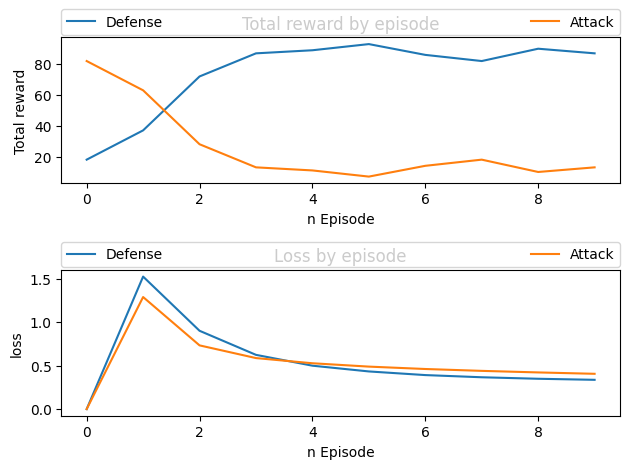

In [37]:
if not os.path.exists('models'):
    os.makedirs('models')
# Save trained model weights and architecture, used in test
defender_agent.model_network.model.save_weights("models/defender_agent_model.weights.h5", overwrite=True)
with open("models/defender_agent_model.json", "w") as outfile:
    json.dump(defender_agent.model_network.model.to_json(), outfile)



if not os.path.exists('results'):
    os.makedirs('results')
# Plot training results
plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(len(def_reward_chain)),def_reward_chain,label='Defense')
plt.plot(np.arange(len(att_reward_chain)),att_reward_chain,label='Attack')
plt.title('Total reward by episode')
plt.xlabel('n Episode')
plt.ylabel('Total reward')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)

plt.subplot(212)
plt.plot(np.arange(len(def_loss_chain)),def_loss_chain,label='Defense')
plt.plot(np.arange(len(att_loss_chain)),att_loss_chain,label='Attack')
plt.title('Loss by episode')
plt.xlabel('n Episode')
plt.ylabel('loss')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=2, mode="expand", borderaxespad=0.)
plt.tight_layout()
#plt.show()
plt.savefig('results/train_adv.eps', format='eps', dpi=1000)

# TEST

In [38]:
from keras.models import model_from_json

import itertools
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import  confusion_matrix

In [39]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [40]:
formated_test_path = "formated_test_adv.data"

with open("models/defender_agent_model.json", "r") as jfile:
    model = model_from_json(json.load(jfile),custom_objects={'huber_loss': huber_loss})
model.load_weights("models/defender_agent_model.weights.h5")

model.compile(loss=huber_loss,optimizer="sgd")


# Define environment, game, make sure the batch_size is the same in train
env_test = RLenv('test',formated_test_path = formated_test_path)


total_reward = 0


true_labels = np.zeros(len(env_test.attack_types),dtype=int)
estimated_labels = np.zeros(len(env_test.attack_types),dtype=int)
estimated_correct_labels = np.zeros(len(env_test.attack_types),dtype=int)

#states , labels = env.get_sequential_batch(test_path,batch_size = env.batch_size)
states , labels = env_test.get_full()


start_time=time.time()
q = model.predict(states)
actions = np.argmax(q,axis=1)

705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [41]:
maped=[]
for indx,label in labels.iterrows():
    maped.append(env_test.attack_types.index(env_test.attack_map[label.idxmax()]))

labels,counts = np.unique(maped,return_counts=True)
true_labels[labels] += counts



for indx,a in enumerate(actions):
    estimated_labels[a] +=1
    if a == maped[indx]:
        total_reward += 1
        estimated_correct_labels[a] += 1


action_dummies = pd.get_dummies(actions)
posible_actions = np.arange(len(env_test.attack_types))
for non_existing_action in posible_actions:
    if non_existing_action not in action_dummies.columns:
        action_dummies[non_existing_action] = np.uint8(0)
labels_dummies = pd.get_dummies(maped)

normal_f1_score = f1_score(labels_dummies[0].to_numpy(),action_dummies[0].to_numpy())
dos_f1_score = f1_score(labels_dummies[1].to_numpy(),action_dummies[1].to_numpy())
probe_f1_score = f1_score(labels_dummies[2].to_numpy(),action_dummies[2].to_numpy())
r2l_f1_score = f1_score(labels_dummies[3].to_numpy(),action_dummies[3].to_numpy())
u2r_f1_score = f1_score(labels_dummies[4].to_numpy(),action_dummies[4].to_numpy())


Accuracy = [normal_f1_score,dos_f1_score,probe_f1_score,r2l_f1_score,u2r_f1_score]
Mismatch = estimated_labels - true_labels

acc = float(100*total_reward/len(states))
print('\r\nTotal reward: {} | Number of samples: {} | Accuracy = {:.2f}%'.format(total_reward,
      len(states),acc))
outputs_df = pd.DataFrame(index = env_test.attack_types,columns = ["Estimated","Correct","Total","F1_score"])
for indx,att in enumerate(env_test.attack_types):
   outputs_df.iloc[indx].Estimated = estimated_labels[indx]
   outputs_df.iloc[indx].Correct = estimated_correct_labels[indx]
   outputs_df.iloc[indx].Total = true_labels[indx]
   outputs_df.iloc[indx].F1_score = Accuracy[indx]*100
   outputs_df.iloc[indx].Mismatch = abs(Mismatch[indx])


print(outputs_df)


Total reward: 15760 | Number of samples: 22544 | Accuracy = 69.91%
       Estimated Correct Total   F1_score
normal      8869    8323  9712  89.586136
DoS         5136    4001  7458  63.538193
Probe       5372    1753  2421  44.989093
R2L         2628    1628  2753  60.509199
U2R          539      55   200   14.88498


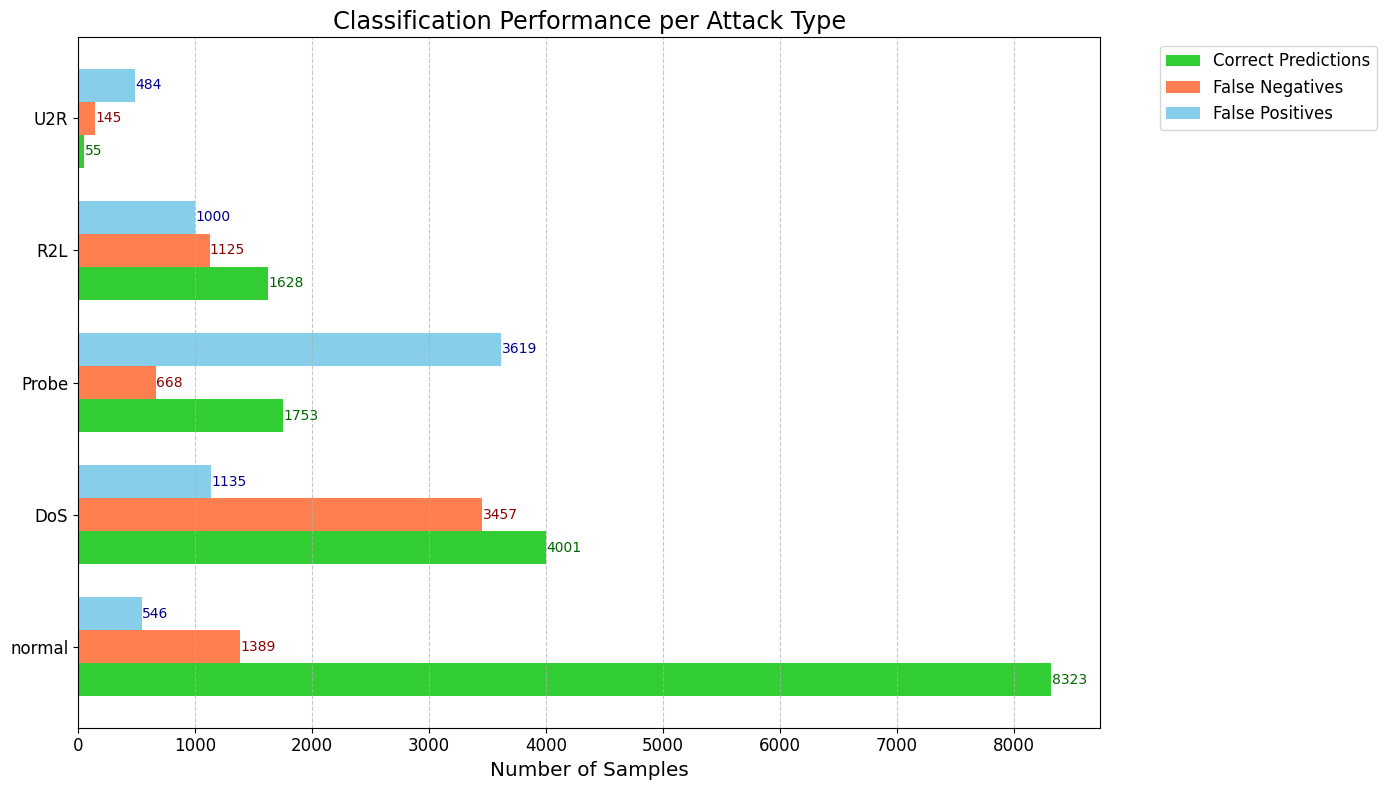

In [42]:

# Define bar properties
bar_height = 0.25
positions = np.arange(len(true_labels))

# Compute data for the bars
false_negatives = np.abs(estimated_correct_labels - true_labels)
false_positives = np.abs(estimated_labels - estimated_correct_labels)

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the bars side by side for each attack type
ax.barh(
    positions - bar_height,
    estimated_correct_labels,
    height=bar_height,
    color='limegreen',
    label='Correct Predictions'
)

ax.barh(
    positions,
    false_negatives,
    height=bar_height,
    color='coral',
    label='False Negatives'
)

ax.barh(
    positions + bar_height,
    false_positives,
    height=bar_height,
    color='skyblue',
    label='False Positives'
)

# Add annotations for clarity
for idx, (correct, fn, fp) in enumerate(zip(estimated_correct_labels, false_negatives, false_positives)):
    ax.text(correct + 2, idx - bar_height, f'{correct}', va='center', fontsize=10, color='darkgreen')
    ax.text(fn + 2, idx, f'{fn}', va='center', fontsize=10, color='darkred')
    ax.text(fp + 2, idx + bar_height, f'{fp}', va='center', fontsize=10, color='darkblue')

# Customize axis ticks and labels
ax.set_yticks(positions)
ax.set_yticklabels(env.attack_types, fontsize='large')
ax.set_xlabel('Number of Samples', fontsize='x-large')
ax.set_title('Classification Performance per Attack Type', fontsize='xx-large')
ax.xaxis.set_tick_params(labelsize=12)

# Add grid for readability
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add a legend outside the plot
ax.legend(fontsize='large', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the updated plot
plt.savefig('results/test_results_nsl_kdd_grouped_horizontal.svg', format='svg', dpi=1000)


In [43]:
estimated_correct_labels

array([8323, 4001, 1753, 1628,   55])

In [44]:
estimated_labels

array([8869, 5136, 5372, 2628,  539])

In [45]:
true_labels

array([9712, 7458, 2421, 2753,  200])

In [46]:
np.abs(estimated_correct_labels-true_labels) # false negative

array([1389, 3457,  668, 1125,  145])

In [47]:
np.abs(estimated_labels-estimated_correct_labels)  #false positive

array([ 546, 1135, 3619, 1000,  484])

Performance measures on Test data
Accuracy =  0.6991
F1 =  0.7197
Precision_score =  0.7736
recall_score =  0.6991
Normalized confusion matrix
[[0.86 0.06 0.06 0.02 0.01]
 [0.06 0.54 0.33 0.06 0.02]
 [0.   0.1  0.72 0.16 0.01]
 [0.03 0.12 0.17 0.59 0.08]
 [0.01 0.06 0.56 0.1  0.28]]


<Figure size 640x480 with 0 Axes>

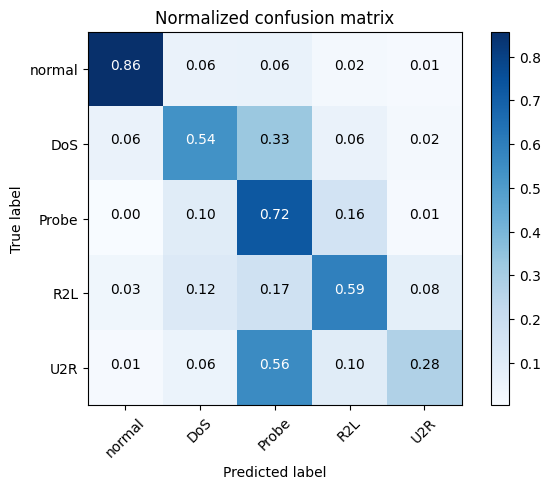

In [48]:
aggregated_data_test = np.array(maped)

print('Performance measures on Test data')
print('Accuracy =  {:.4f}'.format(accuracy_score( aggregated_data_test,actions)))
print('F1 =  {:.4f}'.format(f1_score(aggregated_data_test,actions, average='weighted')))
print('Precision_score =  {:.4f}'.format(precision_score(aggregated_data_test,actions, average='weighted')))
print('recall_score =  {:.4f}'.format(recall_score(aggregated_data_test,actions, average='weighted')))

cnf_matrix = confusion_matrix(aggregated_data_test,actions)
np.set_printoptions(precision=2)
plt.figure()
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=env.attack_types, normalize=True,
                      title='Normalized confusion matrix')
plt.savefig('results/confusion_matrix_adversarial.svg', format='svg', dpi=1000)


In [49]:
mapa = {0:'normal', 1:'DoS', 2:'Probe',3:'R2L',4:'U2R'}
yt_app = pd.Series(maped).map(mapa)

perf_per_class = pd.DataFrame(index=range(len(yt_app.unique())),columns=['name', 'acc','f1', 'pre','rec'])
for i,x in enumerate(pd.Series(yt_app).value_counts().index):
    y_test_hat_check = pd.Series(actions).map(mapa).copy()
    y_test_hat_check[y_test_hat_check != x] = 'OTHER'
    yt_app = pd.Series(maped).map(mapa).copy()
    yt_app[yt_app != x] = 'OTHER'
    ac=accuracy_score( yt_app,y_test_hat_check)
    f1=f1_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    pr=precision_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    re=recall_score( yt_app,y_test_hat_check,pos_label=x, average='binary')
    perf_per_class.iloc[i]=[x,ac,f1,pr,re]

print("\r\nOne vs All metrics: \r\n{}".format(perf_per_class))



One vs All metrics: 
     name       acc        f1       pre       rec
0  normal  0.914168  0.895861  0.938437  0.856981
1     DoS  0.796309  0.635382  0.779011  0.536471
2     R2L   0.90574  0.605092  0.619482  0.591355
3   Probe  0.809839  0.449891  0.326322  0.724081
4     U2R  0.972099   0.14885  0.102041     0.275
